In [1]:
import os
import json
import numpy as np
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nibabel as nib
import matplotlib.pyplot as plt
from dataset import CarotidDataset
from unet import UNet, UNetWrapper
from utils import DiceLoss
from torchvision import transforms

from torchvision.transforms.functional import to_pil_image

In [2]:
batch_size = 1
data = CarotidDataset()
dataloader = torch.utils.data.DataLoader(
    data, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=1)
net = UNetWrapper(in_channels=3, n_classes=1, depth=5, batch_norm=True, padding=True, up_mode='upsample')
net.load_state_dict(torch.load('models/unet.pth'))
net.eval()
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=1)

In [3]:
inputs, labels = next(iter(dataloader))

In [4]:
preds = net(inputs)
preds.shape

torch.Size([1, 1, 256, 256])

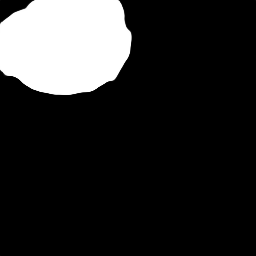

In [5]:
transforms.functional.to_pil_image(preds[0])

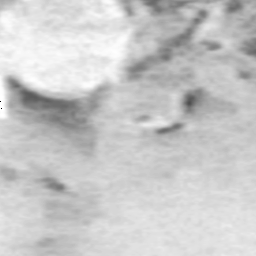

In [6]:
transforms.functional.to_pil_image(inputs[0][2])

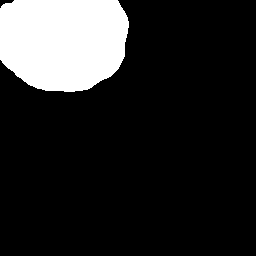

In [7]:
transforms.functional.to_pil_image(labels[0])